In this notebook, we compare GMM-MI with the [KSG estimator](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) and the [MINE estimator](https://github.com/gtegner/mine-pytorch) on a simple bivariate Gaussian with fixed level of correlation, but adding bootstrap to the other estimators, to estimate an error bar. To run this notebook you would need to install the MINE package following the instructions in the repository; here we already cloned the repository for you and adapted the code to work with python 3.9, so that you only need to run:
```
cd mine-pytorch
pip install -e .
```
Note the MINE results are not "reproducible", in the sense that the seed is not fixed.

### Import packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
# GMM-MI
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical
# KSG
from sklearn.feature_selection import mutual_info_regression
# MINE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from mine.models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0

Device: cpu


### Calculate the true MI of the synthetic models

In [2]:
N = 2e2
n_components = 1
weights = np.array([1.])
means = np.zeros((1, 2))
C0 = [[1, 0.6], [0.6, 1]] # correlation is fixed to 0.6
covariances = np.array([C0])
# fix random state for stability across runs
random_state = 13
analytic = calculate_MI_D1_analytical(covariances[0])

# get data whose MI distribution we want to calculate
gmm_true = GMM(n_components=n_components, weights_init=weights, means_init=means, 
               covariances_init=covariances, random_state=random_state)
X = gmm_true.sample(N)[0]

### KSG

In [3]:
knn_estimates_bs = []
n_bootstrap = 20
n_neighbors = 3 # to reproduce the results from Holmes and Nemenman

initial_time = time.time()

# bootstrap available samples
for n_b in range(n_bootstrap):
    # we use i to change the seed so that the results will be fully reproducible
    rng = np.random.default_rng(n_b)
    X_bs = rng.choice(X, X.shape[0])
    knn_estimates_bs.append(mutual_info_regression(X_bs[:, 0].reshape(-1, 1), X_bs[:, 1], 
                                                   n_neighbors=n_neighbors))

ksg_time = time.time()-initial_time    
    
print(f'Total time for KSG: {ksg_time:.3f} s')

Total time for KSG: 0.038 s


### MINE

In [4]:
mine_estimates_bs = []

dim = 1
lr = 1e-3
epochs = 50
batch_size = 32
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()

# bootstrap available samples
for n_b in range(n_bootstrap):
    # we use i to change the seed so that the results will be fully reproducible
    rng = np.random.default_rng(n_b)
    X_bs = rng.choice(X, X.shape[0])

    N = X_bs.shape[0]
    train_size = int(0.9 * N)
    test_size = N - train_size

    train_set, test_set = train_test_split(X_bs, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)
    
    trainer = Trainer(max_epochs=epochs)
    trainer.fit(model)
    trainer.test()

    mine_estimates_bs.append(model.avg_test_mi)

mine_time = time.time()-initial_time    
    
print(f'Total time for MINE: {mine_time:.3f} s')

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightnin

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v180.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v180.ckpt
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off 

Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v181.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v181.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v182.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v182.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v183.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v183.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v184.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v184.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v185.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v185.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v186.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v186.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v187.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v187.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v188.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v188.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v189.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v189.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v190.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v190.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v191.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v191.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v192.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v192.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v193.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v193.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v194.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v194.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v195.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v195.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v196.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v196.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v197.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v197.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v198.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v198.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v199.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_455820/checkpoints/epoch=49-step=300-v199.ckpt


Testing: 0it [00:00, ?it/s]

Total time for MINE: 54.941 s


### GMM-MI

In [5]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=3,
                                                       n_folds=2)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=20,
                                   MC_samples=1e4)

In [6]:
initial_time = time.time()

mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                          select_components_params=select_components_params,
                          mi_dist_params=mi_dist_params)
MI_mean, MI_std = mi_estimator.fit(X)     

gmm_mi_time = time.time()-initial_time
print(f'Total time for GMM: {gmm_mi_time:.3f} s')

100%|██████████| 20/20 [00:00<00:00, 291.15it/s]

Total time for GMM: 0.463 s


### Plot results

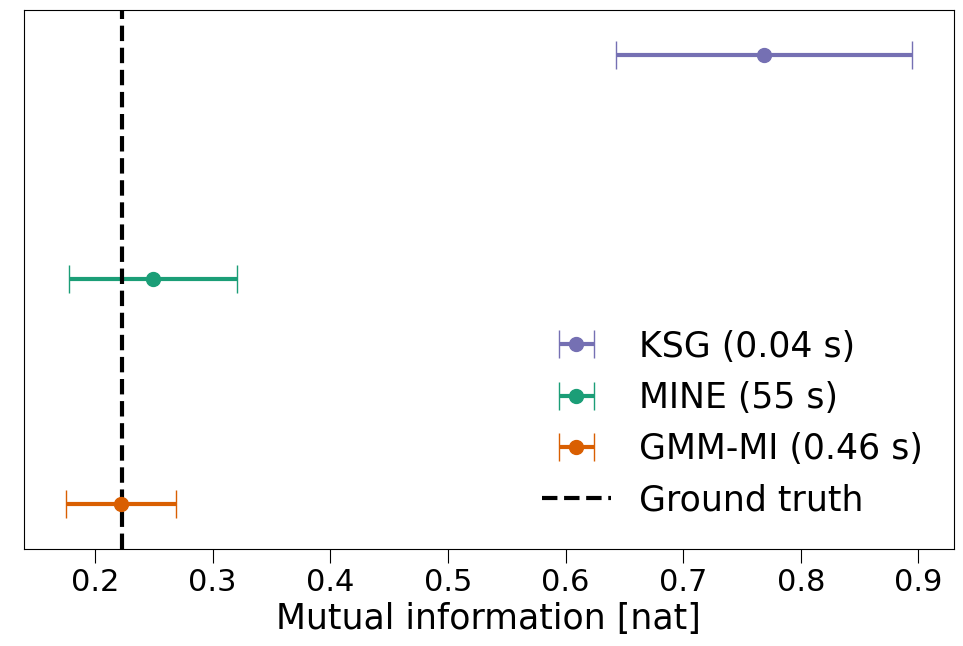

In [7]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 1
lw = 3

ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.errorbar(np.mean(knn_estimates_bs), 0.6, xerr=sigmas*np.std(knn_estimates_bs), yerr=None, fmt='.', 
            markersize=20, color='#7570b3', capsize=10, elinewidth=lw, label=f'KSG ({ksg_time:.2f} s)')
ax.errorbar(np.mean(mine_estimates_bs), 0.5, xerr=sigmas*np.std(mine_estimates_bs), yerr=None, fmt='.', 
            markersize=20, color='#1b9e77', capsize=10, elinewidth=lw, label=f'MINE ({mine_time:.0f} s)')
ax.errorbar(MI_mean, 0.4, yerr=None, xerr=sigmas*MI_std, fmt='.', markersize=20, color='#d95f02', 
            capsize=10, elinewidth=lw, label=f'GMM-MI ({gmm_mi_time:.2f} s)')
ax.axvline(analytic, 0, linestyle='--', lw=3, color='k', label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = 0, 1
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

i1, i2 = 1, 2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

i1, i2 = 2, 3
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1]

ax.legend(handles, labels, fontsize=25, frameon=False, loc='lower right')
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))

ax.set_xlabel('Mutual information [nat]', fontsize=25);
plt.savefig('./figures/MI_bootstrap.pdf',  bbox_inches='tight');